In [2]:
import time
t0 = time.perf_counter()

import pandas as pd
import numpy as np
import math
from operator import itemgetter

print('############################################################################################')
print('Project: Optimal Rebalancing Strategy Using Dynamic Programming for Institutional Portfolios')
print('############################################################################################')
print(' ')

Data = pd.read_csv('Data.csv')

retA = Data['Close_A'].to_numpy() / np.roll(Data['Close_A'].to_numpy(), 1) - 1.0
retB = Data['Close_B'].to_numpy() / np.roll(Data['Close_B'].to_numpy(), 1) - 1.0
retA[0] = 0.0
retB[0] = 0.0

n = len(Data)

varA = np.var(retA, ddof=1)
varB = np.var(retB, ddof=1)
covAB = np.cov(retA, retB, ddof=1)[0, 1]


detail = 0.0005
w_grid = np.arange(0.0, 1.0 + detail, detail)         # candidate weights for A
initial_amount = 1_000_000_000
CA_bps = 60
CB_bps = 40





############################################################################################
Project: Optimal Rebalancing Strategy Using Dynamic Programming for Institutional Portfolios
############################################################################################
 


In [3]:
w_grid

array([0.000e+00, 5.000e-04, 1.000e-03, ..., 9.990e-01, 9.995e-01,
       1.000e+00])

In [4]:
w = w_grid
var_port = (w*w)*varA + ((1-w)*(1-w))*varB + 2.0*w*(1.0-w)*covAB
idx_min = np.argmin(var_port)
Optimal_WeightA = float(w_grid[idx_min])

In [5]:
print('Optimal Portfolio Weight According to Efficient Frontier Using Mean-Variance Optimization: ' + str(Optimal_WeightA))


Optimal Portfolio Weight According to Efficient Frontier Using Mean-Variance Optimization: 0.6145


In [ ]:
cumA = np.cumprod(1.0 + retA)
cumB = np.cumprod(1.0 + retB)

A_val = Optimal_WeightA * initial_amount * cumA
B_val = (1.0 - Optimal_WeightA) * initial_amount * cumB

V = A_val + B_val
V_prev = np.roll(V, 1)
V_prev[0] = V[0]
total_ret = V / V_prev - 1.0
total_ret[0] = 0.0

# Running mean of total returns (prefix mean)
cum_sum_tr = np.cumsum(total_ret)
idxs = np.arange(1, n + 1)
mean_tr_prefix = cum_sum_tr / idxs

EU_current = np.log(1.0 + mean_tr_prefix)

var_opt_term = ((retA - total_ret) ** 2) * (Optimal_WeightA ** 2) + \
               ((retB - total_ret) ** 2) * ((1.0 - Optimal_WeightA) ** 2) + \
               2.0 * (1.0 - Optimal_WeightA) * (Optimal_WeightA) * covAB



In [9]:
var_opt_term.shape

(326,)

In [10]:
EU_optimal = np.log(1.0 + mean_tr_prefix) - var_opt_term / (2.0 * (1.0 + mean_tr_prefix) ** 2)

In [11]:
CEC_norebal = (np.exp(EU_optimal) - np.exp(EU_current)) * 10.0 * initial_amount
CEC_norebal[0] = 0.0

print('Cost of not rebalancing to Optimal Portfolio Weight: ' + str(np.abs(np.sum(CEC_norebal))))
print(' ')

Cost of not rebalancing to Optimal Portfolio Weight: 33437813.2506119
 


In [15]:
EU_prefix_log = np.log(1.0 + mean_tr_prefix)
EU_prefix_denom = 2.0 * (1.0 + mean_tr_prefix) ** 2



In [16]:
Min_Cost_Weight = np.zeros(n)
TC = np.zeros(n)      # transaction cost at t if rebalanced to min-cost weight
CEC = np.zeros(n)     # certainty-equivalent cost at t for chosen weight
Costs = np.zeros(n)   # total cost at t at chosen weight
Low_Bound = np.zeros(n)
High_Bound = np.zeros(n)

In [17]:
for t in range(1, n):
    # Broadcast candidate weights
    W = w_grid

    # Variance_current(W) (replicating your original formula for current portfolio variance)
    # It used retA[t], retB[t], total_ret[t], covAB:
    diffA = (retA[t] - total_ret[t])
    diffB = (retB[t] - total_ret[t])
    var_current_W = (diffA*diffA) * (W*W) + (diffB*diffB) * ((1.0 - W) ** 2) + 2.0 * (1.0 - W) * W * covAB

    # EU_current(W) at time t (prefix part is constant at t)
    EU_current_W = EU_prefix_log[t] - var_current_W / EU_prefix_denom[t]

    # Variance if optimal weight was selected (replicate your formula; only cross-term used W)
    # var_opt_W = (diffA*diffA) * (Optimal_WeightA ** 2) + \
    #             (diffB*diffB) * ((1.0 - Optimal_WeightA) ** 2) + \
    #             2.0 * (1.0 - Optimal_WeightA) * W * covAB

    w_opt = Optimal_WeightA

    var_opt_W = (diffA*diffA) * (w_opt ** 2) \
          + (diffB*diffB) * ((1.0 - w_opt) ** 2) \
          + 2.0 * w_opt * (1.0 - w_opt) * covAB


    EU_opt_W = EU_prefix_log[t] - var_opt_W / EU_prefix_denom[t]

    # CEC_t(W)
    CEC_W = (np.exp(EU_opt_W) - np.exp(EU_current_W)) * initial_amount  # (no *10 here in your DP block)

    # Transaction cost in bps (as in your code)
    TC_W = (CA_bps * np.abs(Optimal_WeightA - W) +
            CB_bps * np.abs((1.0 - Optimal_WeightA) - (1.0 - W)))

    # Total cost
    Costs_W = CEC_W + TC_W

    # Argmin
    j = int(np.argmin(Costs_W))
    Min_Cost_Weight[t] = W[j]
    TC[t] = TC_W[j]
    CEC[t] = CEC_W[j]
    Costs[t] = Costs_W[j]

    # Thresholds where cost < 0  (find lowest/ highest weight with negative cost)
    neg_mask = Costs_W < 0.0
    if np.any(neg_mask):
        idxs = np.nonzero(neg_mask)[0]
        Low_Bound[t] = W[idxs[0]]
        High_Bound[t] = W[idxs[-1]]
    else:
        Low_Bound[t] = 0.0
        High_Bound[t] = 0.0

    if t % max(1, n // 20) == 0 or t == n - 1:
        print('Finished with ' + str(t) + ' out of ' + str(n - 1) + ' Datapoints')

Finished with 16 out of 325 Datapoints
Finished with 32 out of 325 Datapoints
Finished with 48 out of 325 Datapoints
Finished with 64 out of 325 Datapoints
Finished with 80 out of 325 Datapoints
Finished with 96 out of 325 Datapoints
Finished with 112 out of 325 Datapoints
Finished with 128 out of 325 Datapoints
Finished with 144 out of 325 Datapoints
Finished with 160 out of 325 Datapoints
Finished with 176 out of 325 Datapoints
Finished with 192 out of 325 Datapoints
Finished with 208 out of 325 Datapoints
Finished with 224 out of 325 Datapoints
Finished with 240 out of 325 Datapoints
Finished with 256 out of 325 Datapoints
Finished with 272 out of 325 Datapoints
Finished with 288 out of 325 Datapoints
Finished with 304 out of 325 Datapoints
Finished with 320 out of 325 Datapoints
Finished with 325 out of 325 Datapoints


In [18]:
Total_Costs = np.zeros(n)
Total_Costs[1:] = np.cumsum((TC + CEC)[1:])

# ------------------------------------------------------------------------------------
# 5) Forward rebalancing simulation (single pass, no nested recomputation)
# ------------------------------------------------------------------------------------
New_WeightA = np.zeros(n)
Rebalance = np.zeros(n, dtype=int)

# Start from initial allocation
A_val_rb = Optimal_WeightA * initial_amount
B_val_rb = (1.0 - Optimal_WeightA) * initial_amount

New_WeightA[0] = Optimal_WeightA

for t in range(1, n):
    # Grow values with returns of period t
    A_val_rb *= (1.0 + retA[t])
    B_val_rb *= (1.0 + retB[t])

    wt = A_val_rb / (A_val_rb + B_val_rb)
    New_WeightA[t] = wt

    # Check thresholds at time t
    if (wt > Low_Bound[t]) and (wt < High_Bound[t]):
        Rebalance[t] = 0
        # no change to A_val_rb / B_val_rb
    else:
        Rebalance[t] = 1
        # Rebalance NOW to min-cost weight at time t (applied immediately)
        w_star = Min_Cost_Weight[t]
        total_val = A_val_rb + B_val_rb
        A_val_rb = w_star * total_val
        B_val_rb = (1.0 - w_star) * total_val
        New_WeightA[t] = w_star  # reflect post-rebalance weight at time t

# ------------------------------------------------------------------------------------
# 6) Total costs of rebalancing using DP (same scale factor as your code)
# ------------------------------------------------------------------------------------
TC_DM = np.sum((TC * 1000.0)[Rebalance == 1])

print(' ')
print('Total Costs of Rebalancing using Dynamic Programming ' + str(TC_DM))

 
Total Costs of Rebalancing using Dynamic Programming 1042749.9999999999


In [19]:
out = pd.DataFrame({
    'Close_A': Data['Close_A'],
    'Close_B': Data['Close_B'],
    'Returns_A': retA,
    'Returns_B': retB,
    'WeightA': A_val / (A_val + B_val),          # drift-only weight
    'Min_Cost_Weight': Min_Cost_Weight,
    'TC': TC,
    'CEC': CEC,
    'Total_Costs': Total_Costs,
    'Low_Bound': Low_Bound,
    'High_Bound': High_Bound,
    'Rebalance': Rebalance,
    'New_WeightA': New_WeightA,
})

out.to_csv('Optimal.csv', index=False)

In [20]:
# ------------------------------------------------------------------------------------
# Timing
# ------------------------------------------------------------------------------------
print('Total Run Time: ' + str(time.perf_counter() - t0))

Total Run Time: 2109.769206899975


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the output file generated by your model
df = pd.read_csv("Optimal.csv")

# Quick check of the columns
print(df.columns)
df.head()


Index(['Close_A', 'Close_B', 'Returns_A', 'Returns_B', 'WeightA',
       'Min_Cost_Weight', 'TC', 'CEC', 'Total_Costs', 'Low_Bound',
       'High_Bound', 'Rebalance', 'New_WeightA'],
      dtype='object')


,Close_A,Close_B,Returns_A,Returns_B,WeightA,Min_Cost_Weight,TC,CEC,Total_Costs,Low_Bound,High_Bound,Rebalance,New_WeightA
0,57.74,780.59,0.000000,0.000000,0.614500,0.0000,0.00,0.000000,0.000000,0.000,0.0000,0,0.614500
1,57.18,789.90,-0.009699,0.011927,0.609370,0.7110,9.65,-1193.904244,-1184.254244,0.615,0.8075,1,0.711000
2,57.47,786.10,0.005072,-0.004811,0.611720,0.6820,6.75,-139.385820,-1316.890064,0.615,0.7495,0,0.713026
3,57.22,785.75,-0.004350,-0.000445,0.610790,0.6145,0.00,0.000000,-1316.890064,0.000,0.0000,1,0.614500
4,56.90,785.09,-0.005592,-0.000840,0.609656,0.6280,1.35,-3.010100,-1318.550164,0.615,0.6410,1,0.628000


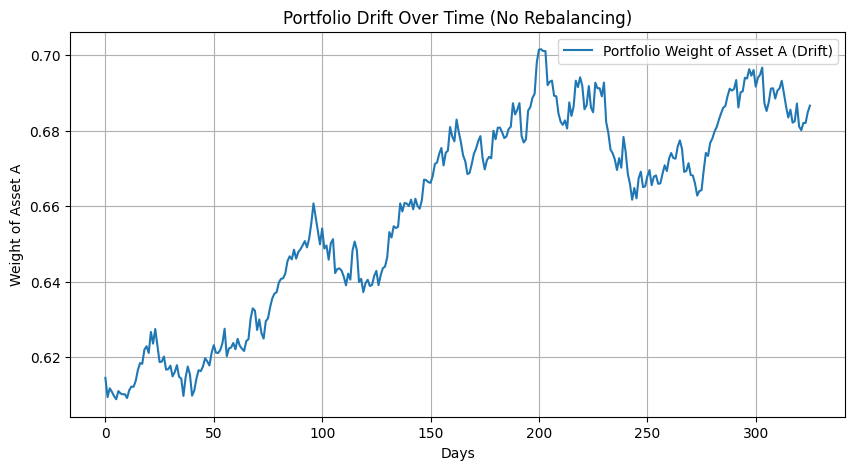

In [22]:
plt.figure(figsize=(10,5))
plt.plot(df['WeightA'], label='Portfolio Weight of Asset A (Drift)')
plt.title('Portfolio Drift Over Time (No Rebalancing)')
plt.xlabel('Days')
plt.ylabel('Weight of Asset A')
plt.legend()
plt.grid(True)
plt.show()

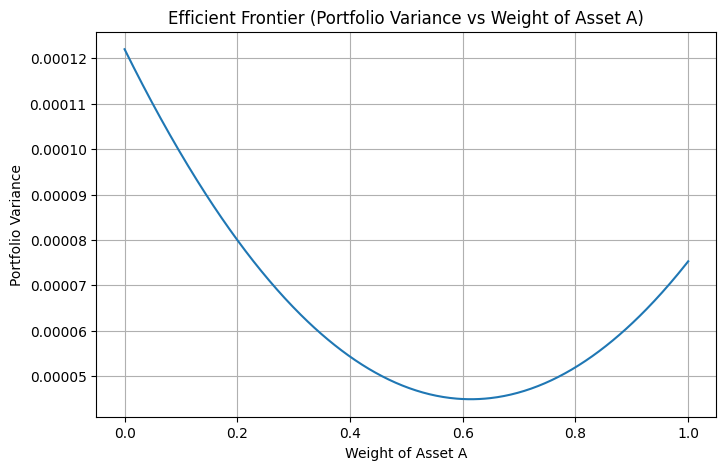

In [23]:
import numpy as np

# Recompute the variance curve just for visualization
w_grid = np.linspace(0, 1, 500)
varA = df['Returns_A'].var()
varB = df['Returns_B'].var()
covAB = np.cov(df['Returns_A'], df['Returns_B'])[0,1]

var_port = (w_grid**2)*varA + ((1-w_grid)**2)*varB + 2*w_grid*(1-w_grid)*covAB

plt.figure(figsize=(8,5))
plt.plot(w_grid, var_port)
plt.title('Efficient Frontier (Portfolio Variance vs Weight of Asset A)')
plt.xlabel('Weight of Asset A')
plt.ylabel('Portfolio Variance')
plt.grid(True)
plt.show()


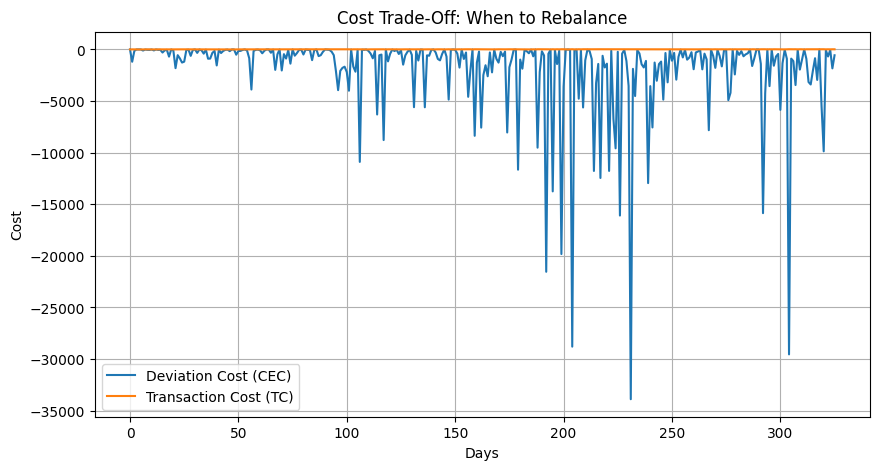

In [24]:
plt.figure(figsize=(10,5))
plt.plot(df['CEC'], label='Deviation Cost (CEC)')
plt.plot(df['TC'], label='Transaction Cost (TC)')
plt.title('Cost Trade-Off: When to Rebalance')
plt.xlabel('Days')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()


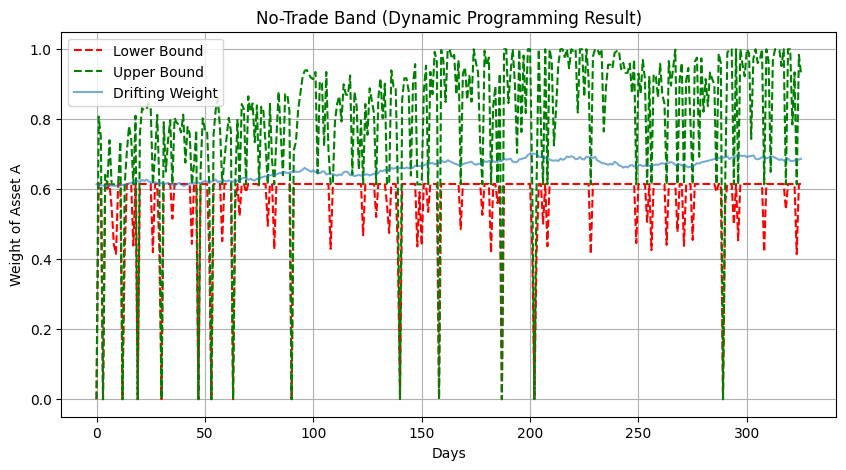

In [25]:
plt.figure(figsize=(10,5))
plt.plot(df['Low_Bound'], label='Lower Bound', linestyle='--', color='r')
plt.plot(df['High_Bound'], label='Upper Bound', linestyle='--', color='g')
plt.plot(df['WeightA'], label='Drifting Weight', alpha=0.6)
plt.title('No-Trade Band (Dynamic Programming Result)')
plt.xlabel('Days')
plt.ylabel('Weight of Asset A')
plt.legend()
plt.grid(True)
plt.show()


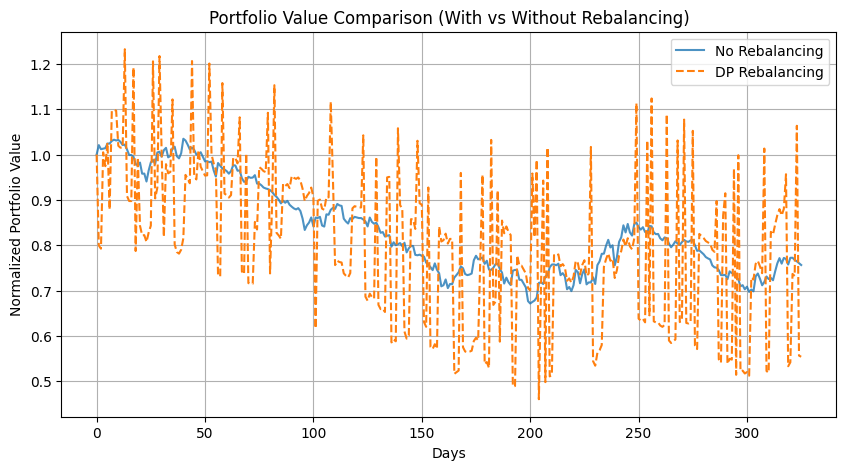

In [26]:
val_no_rebal = df['WeightA']*df['Close_A'] + (1-df['WeightA'])*df['Close_B']
val_rebal = df['New_WeightA']*df['Close_A'] + (1-df['New_WeightA'])*df['Close_B']

plt.figure(figsize=(10,5))
plt.plot(val_no_rebal / val_no_rebal.iloc[0], label='No Rebalancing', alpha=0.8)
plt.plot(val_rebal / val_rebal.iloc[0], label='DP Rebalancing', linestyle='--')
plt.title('Portfolio Value Comparison (With vs Without Rebalancing)')
plt.xlabel('Days')
plt.ylabel('Normalized Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


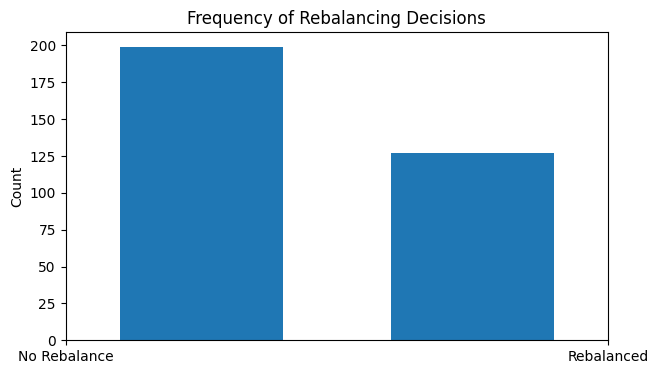

In [27]:
plt.figure(figsize=(7,4))
plt.hist(df['Rebalance'], bins=2, rwidth=0.6)
plt.xticks([0, 1], ['No Rebalance', 'Rebalanced'])
plt.title('Frequency of Rebalancing Decisions')
plt.ylabel('Count')
plt.show()


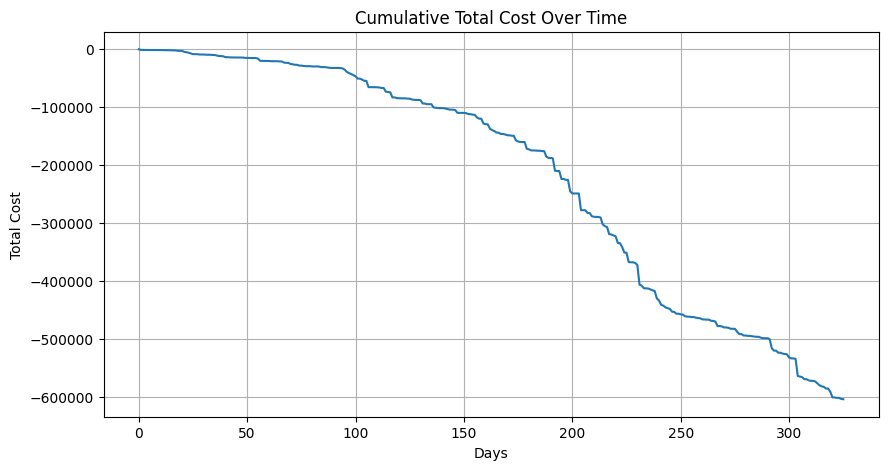

In [28]:
plt.figure(figsize=(10,5))
plt.plot(df['Total_Costs'])
plt.title('Cumulative Total Cost Over Time')
plt.xlabel('Days')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()


Plotting threshold graph for day t = 149


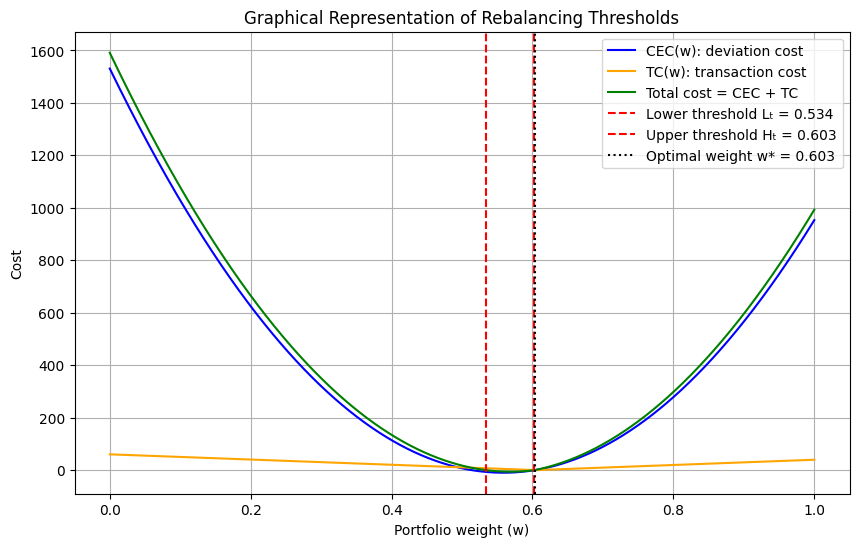

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Parameters (must match main DP code)
# ------------------------------------------------------------
CA_bps = 60
CB_bps = 40
initial_amount = 1_000_000_000

detail = 0.0005
w_grid = np.arange(0.0, 1.0 + detail, detail)

# ------------------------------------------------------------
# 2) Choose a day where rebalancing actually happened
# ------------------------------------------------------------
rebalance_days = out.index[out['Rebalance'] == 1].tolist()
if len(rebalance_days) > 0:
    t = rebalance_days[len(rebalance_days)//2]
else:
    t = len(out)//2

print(f"Plotting threshold graph for day t = {t}")

# ------------------------------------------------------------
# 3) Extract correct quantities for day t
# ------------------------------------------------------------
retA_t = out.loc[t, 'Returns_A']
retB_t = out.loc[t, 'Returns_B']

# Optimal weight chosen by DP on day t
w_star = out.loc[t, 'Min_Cost_Weight']

# Covariance (same as used in DP)
covAB = np.cov(out['Returns_A'], out['Returns_B'], ddof=1)[0, 1]

# Prefix mean return up to day t (portfolio mean)
portfolio_returns_prefix = (
    out['Returns_A'][:t] * w_star +
    out['Returns_B'][:t] * (1.0 - w_star)
)

mu = np.mean(portfolio_returns_prefix)

# Log-utility expansion constants (NATURAL LOG)
EU_prefix = np.log(1.0 + mu)
EU_denom = 2.0 * (1.0 + mu) ** 2

# ------------------------------------------------------------
# 4) Correct deviation terms (VERY IMPORTANT)
# ------------------------------------------------------------
total_ret_t = w_star * retA_t + (1.0 - w_star) * retB_t

diffA = retA_t - total_ret_t
diffB = retB_t - total_ret_t

# ------------------------------------------------------------
# 5) Variance when CURRENT weight is w
# ------------------------------------------------------------
var_current_W = (
    (diffA**2) * (w_grid**2) +
    (diffB**2) * ((1.0 - w_grid)**2) +
    2.0 * w_grid * (1.0 - w_grid) * covAB
)

EU_current_W = EU_prefix - var_current_W / EU_denom

# ------------------------------------------------------------
# 6) Variance when rebalanced to OPTIMAL weight (constant!)
# ------------------------------------------------------------
var_opt = (
    (diffA**2) * (w_star**2) +
    (diffB**2) * ((1.0 - w_star)**2) +
    2.0 * w_star * (1.0 - w_star) * covAB
)

EU_opt = EU_prefix - var_opt / EU_denom

# ------------------------------------------------------------
# 7) Certainty Equivalent Cost (CEC)
# ------------------------------------------------------------
CEC_W = (np.exp(EU_opt) - np.exp(EU_current_W)) * initial_amount

# ------------------------------------------------------------
# 8) Transaction Cost (TC)
# ------------------------------------------------------------
TC_W = (
    CA_bps * np.abs(w_star - w_grid) +
    CB_bps * np.abs((1.0 - w_star) - (1.0 - w_grid))
)

# ------------------------------------------------------------
# 9) Total cost and thresholds
# ------------------------------------------------------------
TotalCost_W = CEC_W + TC_W

neg_mask = TotalCost_W < 0.0
if np.any(neg_mask):
    idxs = np.where(neg_mask)[0]
    L_t = w_grid[idxs[0]]
    H_t = w_grid[idxs[-1]]
else:
    L_t, H_t = None, None

# ------------------------------------------------------------
# 10) Plot
# ------------------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(w_grid, CEC_W, label='CEC(w): deviation cost', color='blue')
plt.plot(w_grid, TC_W, label='TC(w): transaction cost', color='orange')
plt.plot(w_grid, TotalCost_W, label='Total cost = CEC + TC', color='green')

if L_t is not None:
    plt.axvline(L_t, color='red', linestyle='--', label=f'Lower threshold Lₜ = {L_t:.3f}')
    plt.axvline(H_t, color='red', linestyle='--', label=f'Upper threshold Hₜ = {H_t:.3f}')

plt.axvline(w_star, color='black', linestyle=':', label=f'Optimal weight w* = {w_star:.3f}')

plt.title('Graphical Representation of Rebalancing Thresholds')
plt.xlabel('Portfolio weight (w)')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()
